In [1]:
# Load required packages
from dynamic_stock_model import DynamicStockModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define formating for graphs 
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'axes.linewidth': .5})
plt.rcParams.update({'legend.fontsize': 10})
 
fig_size_mult = 1.3
fig_size_tuple = (4 * fig_size_mult, 3 * fig_size_mult);
fig_size_tuple_double = (8 * fig_size_mult * .5/ .7, 3 * fig_size_mult * .5/ .7);
fig_dpi = 100

%matplotlib inline
# this is only for the IPython notebook, not part of the python script!

In [2]:
# Read data
# Spreadsheet came from: https://pubs.acs.org/doi/abs/10.1021/es502930w
Cars_Datafile  = pd.read_excel('../data/es502930w_si_002.xlsx', 
                               sheet_name='3.Use', 
                               skiprows = 5, 
                               usecols = 'A,C,F,I',
                              )

Cars_Datafile.columns = ['Year', 'Population', 'Car/capita', 'Lifetime']

Years = Cars_Datafile['Year'].to_list()
Population = Cars_Datafile['Population'].to_list()
CarOwnership = Cars_Datafile['Car/capita'].to_list()

# Number from Table S1 of https://ars.els-cdn.com/content/image/1-s2.0-S0921344913002619-mmc1.docx
CarLifetime = [13] * len(Years)

# Data from: https://greet.es.anl.gov/files/light-duty-vehicle-2016 (Table 1)
glass_weight = np.mean([97,  99,  100, 99,  101, 103, 104, 
                        104, 105, 105, 104, 105, 106, 106, 
                        93,  94,  98,  95,  96,  96,]) * 0.453592

CarGlassContent = [glass_weight] * len(Years)

# Get total number of cars
TotalVehicleStock = [a * b / 1000 for (a,b) in zip(Population,CarOwnership)] 

In [3]:
# Model pre-checks
GlobalVehicles_DSM = DynamicStockModel(t = Years, s = TotalVehicleStock, 
                                      lt = {'Type': 'Normal', 'Mean': np.array(CarLifetime), 
                                            'StdDev': 0.3*np.array(CarLifetime) })

CheckStr, ExitFlag = GlobalVehicles_DSM.dimension_check()

# Solve model
S_C, O_C, I, ExitFlag = GlobalVehicles_DSM.compute_stock_driven_model()

O, ExitFlag   = GlobalVehicles_DSM.compute_outflow_total() # Total outflow
DS, ExitFlag  = GlobalVehicles_DSM.compute_stock_change()  # Stock change
Bal, ExitFlag = GlobalVehicles_DSM.check_stock_balance()   # Vehicle balance

# Get glass flows
Inflow_Glass = GlobalVehicles_DSM.i * np.array(CarGlassContent)
Outflow_Glass = GlobalVehicles_DSM.o * np.array(CarGlassContent)

# Get glass stocks
Glass_Stock_ByCohort = np.einsum('tc,c->tc',GlobalVehicles_DSM.s_c,CarGlassContent) # in kg, s_c has dimension year x cohort
# index t stands for year/time, index c for age-cohort

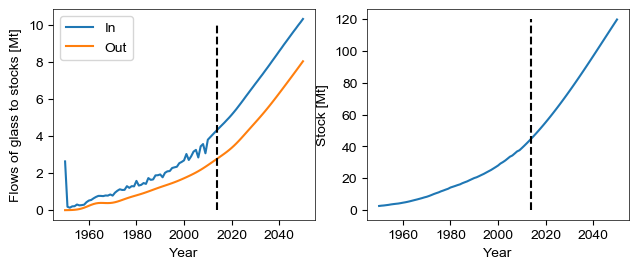

In [4]:
fig, ax=plt.subplots(1, 2, figsize = fig_size_tuple_double, dpi = fig_dpi, facecolor='w', edgecolor='k', sharex=True)

# Flows to stock
ax[0].plot(GlobalVehicles_DSM.t, Inflow_Glass / 1e9, label = 'In')
ax[0].plot(GlobalVehicles_DSM.t, Outflow_Glass / 1e9, label = 'Out')
ax[0].plot([2014,2014],[0,10], color = 'k', LineStyle = '--')
ax[0].legend()

ax[0].set_xlabel('Year')
ax[0].set_ylabel('Flows of glass to stocks [Mt]')

# Stock of glass
ax[1].plot(GlobalVehicles_DSM.t, Glass_Stock_ByCohort.sum(axis =1) / 1e9)
ax[1].plot([2014,2014],[0,120], color = 'k', LineStyle = '--')

ax[1].set_xlabel('Year')
ax[1].set_ylabel('Stock [Mt]')

plt.savefig('../outputs/auto_glass_stocks.pdf')
plt.show()